1. What are the main motivations for reducing a dataset's dimensionality? What are the main drawbacks \

Motivations: 
- Some algorithms do not scale well with a high number of features
- Working with high-dim datasets means dealing with the curse of dimensionality. Datapoints are very far from one another in high dimensionality space and are considered as outliers (close to the border, or a border at least?). - - Also, high dimensional datasets are at risk of being parse 
- To save space 
- To visualize the data

Some drawbacks: 
- Loss of information when projecting / manifold learning to lower dimensions 
- Loss of interpretability 

2. What is the curse of dimensionality?

As mentioned above, when dealing with high dimensionality datasets, the data is usually very sparse 
-> Models may overfit, and it is hard to identify patterns without a high number of training instances

3. Once dataset dimensionality reduced, is it possible to reverse the operation? If so how? 

In the case of PCA, projecting the data is done using SVD. The reverse operation can be applied, however the reconstructed dataset will not be the same as the original set -> the mean squared error between the original data and the reconstucted set is the reconstruction error 

4. Can PCA be used to reduce the dim. of a highly nonlinear dataset? 

An algorithm that relies on manifold learning (LLE) will be more useful in reducing the dim. of a highly nonlinear dataset, especially when there are no 'useless' dimensions (dimensions that don't explain a certain % of the variance). However, PCA can still be used in some instances where it can get rid of useless dimensions

5. Suppose you perform PCA on a 1000 dim dataset, setting the explained variance raatio to 95%. How many dims will the resulting dataset have? 

It depends on the dataset: If 95% of the var. can be explained in the first 2 dimensions, then these 2 dimensions will be kept. However, if each Principle Component can explain only a marginal % of the variance, then almost all (up to ~950 dims) will be kept 

6. In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA 


- Incremental PCA: Used to split the training seet into mini batches and feed the IPCA 1 mini batch at a time. Use when data doesn't fit in memory 
- Randomized PCA: Faster than PCA, finds an approximation of the first d principle components (w/ a less complex SVD algo?)  
- Kernel PCA: Use to perform complex nopnlinear projections for dim reduction. Can lunroll datasets that lie close to a twisted manifold 

7. How can you evaluate the peerformance of a dim reduction algo?


- Can check reconstruction error with algos that can have the reverse transformation applied 
- If modeling after dim reduction, can check performance of model w/ the lower dim. dataset vs. larger

8. Does it make sense to chain multiple dim reduction algos? 

Yes -> example: Use PCA followed by LLE. Will have same performance as performing LLE alone (more or less) but at a fraction of the time 

## Exercise 9 

In [12]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import time

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [4]:
X = mnist.data
y = mnist.target

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=10000)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
t0 = time.time() 
rf.fit(X_train,y_train)
t1 = time.time() 
print("Training took {:.2f}s".format(t1-t0))

In [ ]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

In [5]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=.95)
X_train_reduced = pca.fit_transform(X_train) 

In [ ]:
X_train_reduced.shape

In [ ]:
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time() 
rf_pca.fit(X_train_reduced,y_train)
t1 = time.time() 
print("Training took {:.2f}s".format(t1-t0))

In [ ]:
X_test_reduced = pca.transform(X_test) ## not fit transfoirm! 

y_pred_reduced = rf_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred_reduced)

## Exercise 10 

In [17]:
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
## Take a subset of the data 
np.random.seed(42)
m = 10000
random_idx = np.random.permutation(60000)[:m]

X = mnist['data'][random_idx]
y = mnist['target'][random_idx]

In [13]:
dim_reduction_pipe = Pipeline([
    ("PCA", PCA(n_components=.95, random_state=42)),
    ("TSNE", TSNE(random_state=42))
])

t0 = time.time()
X_pca_tsne_reduced = dim_reduction_pipe.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
     

PCA+t-SNE took 72.4s.


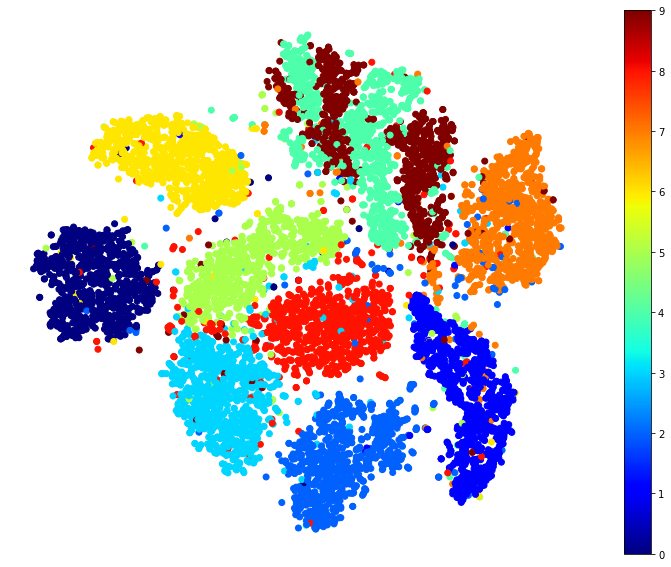

In [20]:
plt.figure(figsize=(13,10))
plt.scatter(X_pca_tsne_reduced[:,0],X_pca_tsne_reduced[:,1],
           c=y,cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

In [26]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=.05, images=None, figsize=(13,10)):
    ## Scale input feature 0-1 
    X_normalized = MinMaxScaler().fit_transform(X)
    
    ## Crerate coordinates of plotted digits 
    neighbors = np.array([[10.,10,]])
    plt.figure(figsize=figsize)
    cmap=mpl.cm.get_cmap('jet')
    digits = np.unique(y)
    for digit in digits: 
        plt.scatter(X_normalized[y==digit,0],
                   X_normalized[y==digit,1], c=[cmap(digit/9)])
    plt.axis('off') 
    ax=plt.gcf().gca() # Get current axes in current figure 
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None: 
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                        color=cmap(y[index]/9), fontdict={"weight":"bold", "size":16})
            else: 
                image = images[index].reshape(28,28)
                imagebox=AnnotationBbox(OffsetImage(image, cmap='binary'), image_coord)
                ax.add_artist(imagebox)

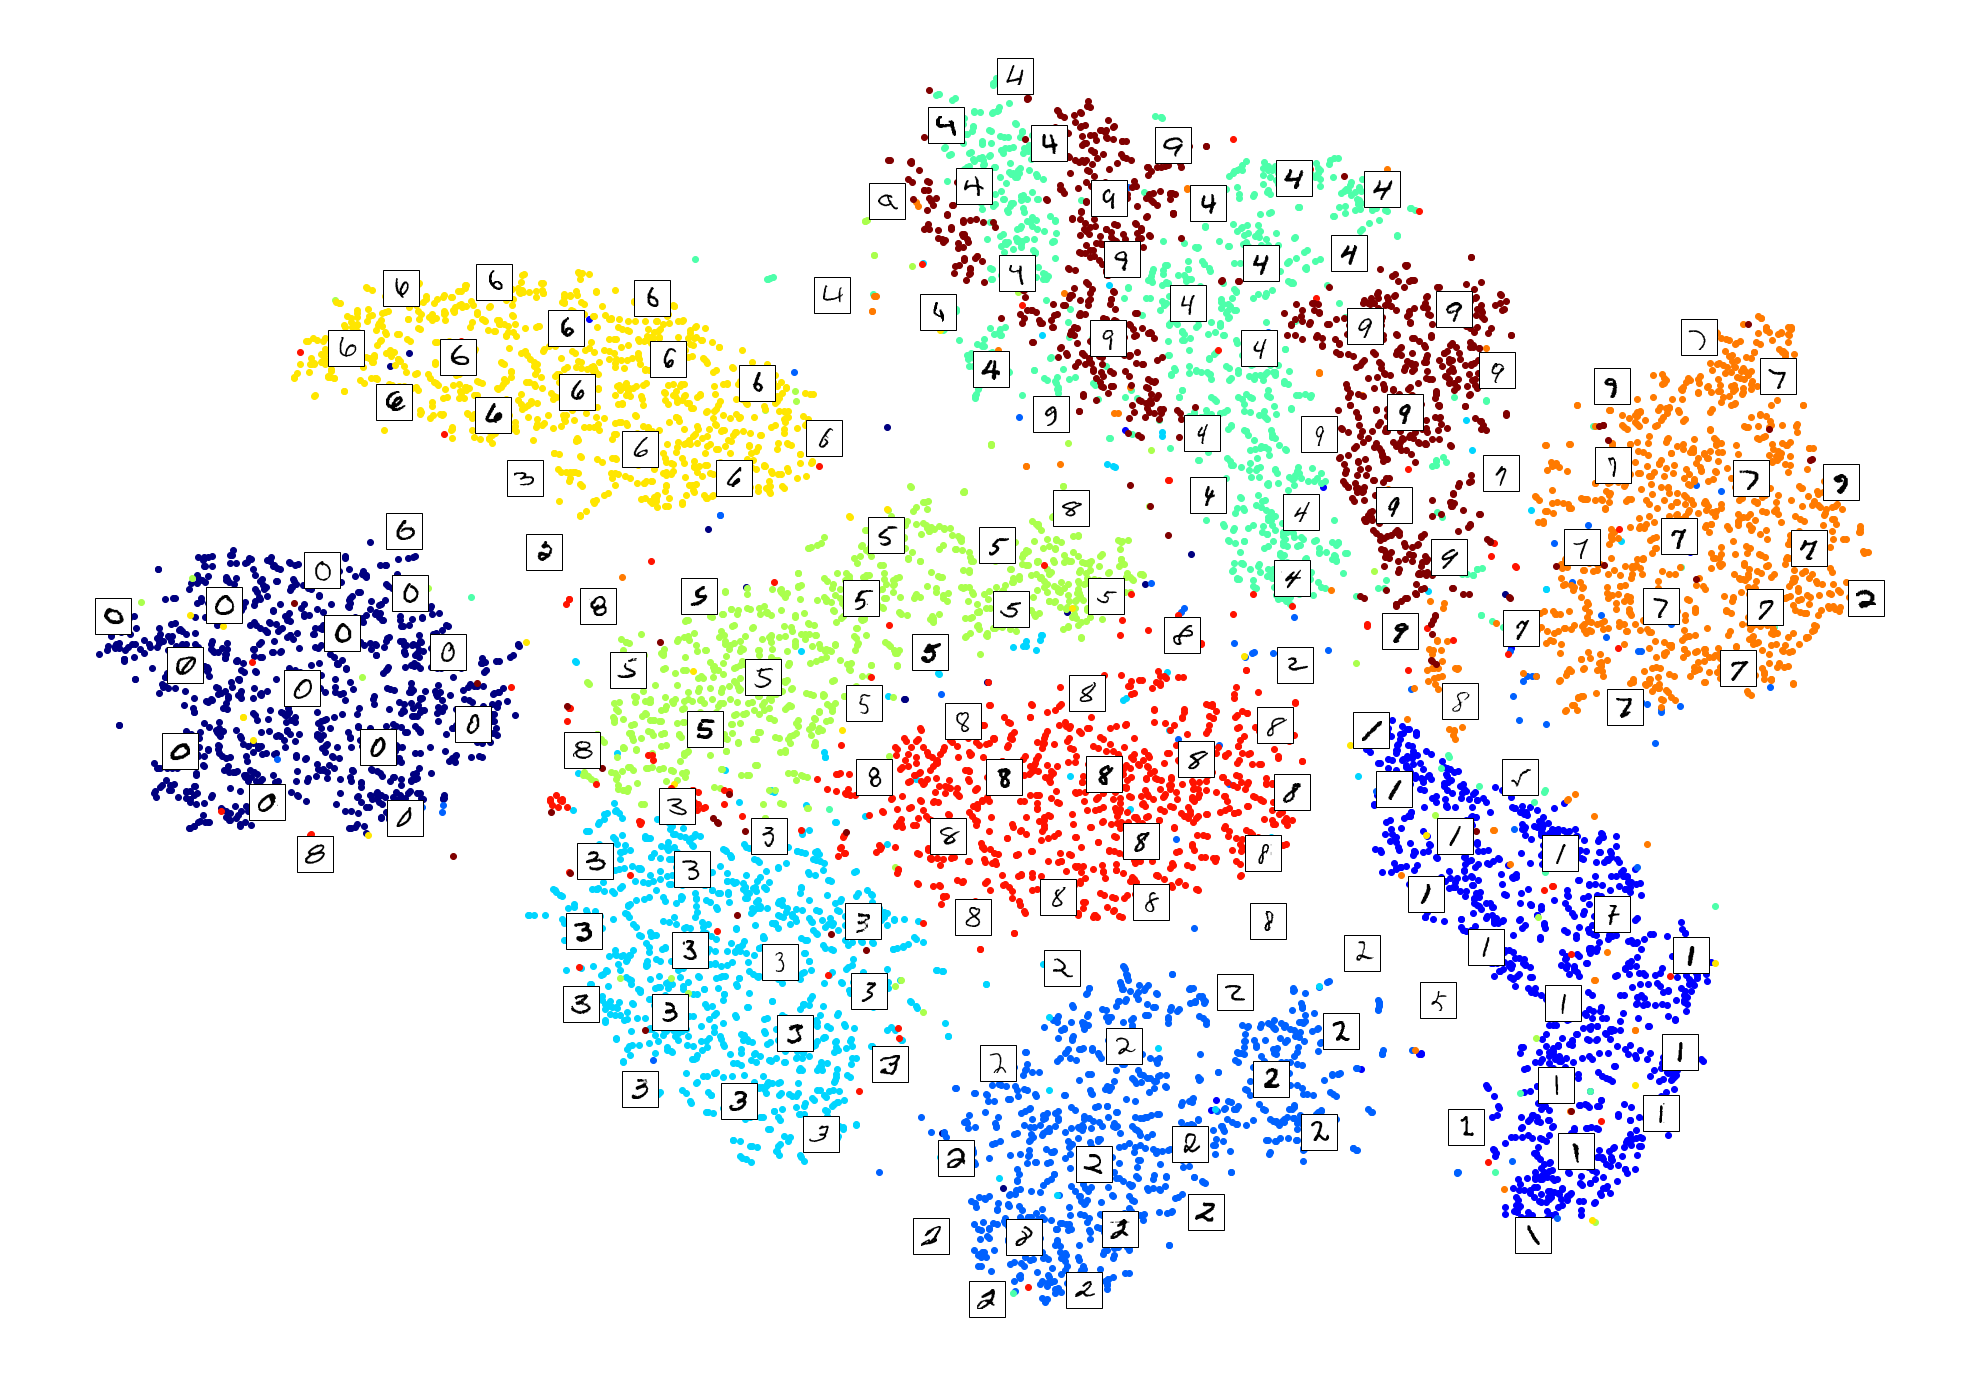

In [29]:
plot_digits(X_pca_tsne_reduced, y, images=X, figsize=(35, 25))


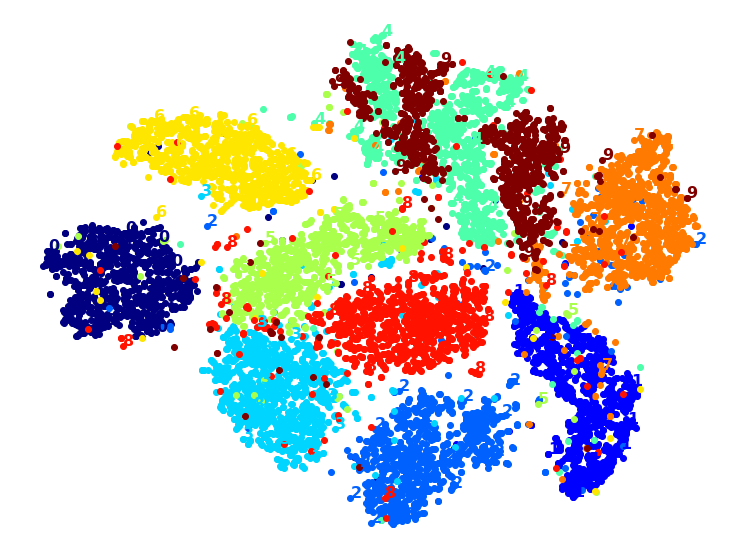

In [30]:
plot_digits(X_pca_tsne_reduced, y)

In [34]:
dim_reduction_pipe["PCA"].explained_variance_ratio_

array([0.09614987, 0.07138535, 0.06078229, 0.05354404, 0.04900231,
       0.04313292, 0.03271349, 0.02897947, 0.02777201, 0.02360331,
       0.0209813 , 0.02067189, 0.01742227, 0.01675011, 0.01586211,
       0.01492888, 0.01322555, 0.01243242, 0.01211256, 0.01165188,
       0.0107649 , 0.01011037, 0.00970329, 0.00910593, 0.00875827,
       0.00828709, 0.00812353, 0.00787857, 0.00744001, 0.00711129,
       0.00668691, 0.00655685, 0.00609595, 0.00592185, 0.00568905,
       0.0054245 , 0.00504581, 0.00501168, 0.0048302 , 0.00472335,
       0.00458885, 0.00444765, 0.00411751, 0.00399406, 0.00381385,
       0.00377168, 0.00361146, 0.00348403, 0.00343807, 0.00323136,
       0.00315393, 0.00309994, 0.00299179, 0.00287607, 0.00282446,
       0.00273911, 0.00271219, 0.00262588, 0.00258858, 0.00245389,
       0.0024171 , 0.00239513, 0.00232433, 0.00220969, 0.00213518,
       0.00207887, 0.00204117, 0.00197486, 0.00193128, 0.00189392,
       0.00185762, 0.00183188, 0.00179227, 0.00176328, 0.00169